# Homework 5

### Overview
This homework assignment is divided into two parts: 1) Prediction of HOLC labels and 2) geodemographic clustering 

### Deliverables: 
1. Pandas notebook with outputs

In [1]:
# We are going to start importing the libraries we need
# all in one cell. 

# It is a good practice to keep all the imports in one cell so that
# we can easily see what libraries we are using in the notebook.
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

## There is no need to import libraries more than once!

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 1. Predicting HOLC grades
In this exercise, you are going to explore some historical Census data and understand its relationships with the Home Owners' Loan Corporation (HOLC) risk maps. These maps were made by the HOLC in the late 1930s-early 1940s for the HOLC to make assessments of neighborhood risk after the HOLC bailed out underwater borrowers who were unable to pay their mortgage loans as a consequence of the Great Depression. Mortgage risk was assessed with all residential neighborhoods being given an A, B, C, or D grade: 

- A = "best"
- B = "still desirable"
- C = "definitely declining"
- D = "hazardous"

While these maps have become known as the "redlining maps" note that the agency didn't use these maps to make decisions on who/where should get loans. They actually made these maps after loan activities were already over! However, these maps do provide an interesting window into how the real estate industry viewed different neighborhoods, during a period when redlining (by savings and loan banks, the Federal Housing Administration, amongst others) occurred. In 1968, Congress signed the Fair Housing Act of 1968, also known as Title VIII of the Civil Rights Act of 1968, that formally made discrimination by race, sex, color, religion, disability, family status, and national origin illegal. This is considered by many scholars to be the legal end of discriminatory redlining practices (although they still occur, in various ways, to today). 

There are three time periods to consider when we're thinking about the "impacts" of the redlining: 
- The pre-redlining period: for now, we'll say that is 1930 and any 1930-1940 trends. 
- The redlining period: 1940 - 1970
- The post-redlining period: 1980 - present

The overall aim of this study is to understand whether we think there is a relationship between HOLC grades and present-day outcomes in racial outcomes and neighborhood outcomes such as education or median income. The underlying mechanism here might be that HOLC grades led to disinvestment in neighborhoods, which leads to poor conditions, the concentration of poverty, and low opportunities for people who live in that neighborhood. This leads us to test two scenarios: 

1. Can we use neighborhood conditions to predict historical HOLC grades during the period of redlining? 
2. Similarly, if we think that grades were also determined by neighborhood socioeconomic and demographic conditions, can we use these to predict HOLC grades? 

## 1.1 Load in the data
The folder `holc_data` can be downloaded [here](https://www.dropbox.com/scl/fo/efovuq4dg9mmrwhtnvak6/AHew7g8n0jqkuxPGpU3lZBQ?rlkey=g7371rzvg8m2duq86hg3jc6nk&dl=0).

In [2]:
### This is a version of the data with all the years as separate columns
holc_data = gpd.read_file('https://www.dropbox.com/scl/fi/i017f3g4juwtf6rmpijcq/holc_data_1930_2016.geojson?rlkey=scxpkogx5hcj1r1rvdwg297g8&dl=1',driver='GeoJSON')

### This is a version of the data with the years concatenated
holc_data_v2 = []
for y in ['1930','1940','1950','1960','1970','1980','1990','2010', '2016']: 
    df = gpd.read_file(f'holc_data/holc_overlay_{y}')
    df['year'] = y
    holc_data_v2.append(df)

holc_data_v2= pd.concat(holc_data_v2)[['city','holc_grade','population','white_perc','colored_pe','hispanic_p','other_perc','college_pe','median_inc','unemployed','geometry','year']]

holc_data_v2 = holc_data_v2.rename(columns={'colored_pe':'black_perc','hispanic_p':'hispanic_perc','college_pe':'college_perc','unemployed':'unemployed_perc'})

In [3]:
holc_data.columns

Index(['city', 'holc_grade', 'holc_id', 'population_2016', 'white_perc_2016',
       'black_perc_2016', 'hispanic_perc_2016', 'other_perc_2016',
       'college_perc_2016', 'median_inc_2016', 'unemployed_perc_2016',
       'population_1930', 'white_perc_1930', 'black_perc_1930',
       'population_1940', 'white_perc_1940', 'black_perc_1940',
       'population_1950', 'white_perc_1950', 'black_perc_1950',
       'other_perc_1950', 'college_perc_1950', 'median_inc_1950',
       'population_1960', 'white_perc_1960', 'hispanic_perc_1960',
       'black_perc_1960', 'other_perc_1960', 'college_perc_1960',
       'median_inc_1960', 'population_1970', 'white_perc_1970',
       'hispanic_perc_1970', 'black_perc_1970', 'other_perc_1970',
       'college_perc_1970', 'median_inc_1970', 'population_1980',
       'white_perc_1980', 'black_perc_1980', 'hispanic_perc_1980',
       'other_perc_1980', 'college_perc_1980', 'median_inc_1980',
       'unemployed_perc_1980', 'population_1990', 'white_perc_1

In [4]:
pd.set_option('display.max_rows', None)

print(holc_data.city)

#there seems to be multiple entries with same city name (probably different districts)

pd.reset_option('display.max_rows')

0                                  Akron
1                                 Albany
2                                Altoona
3                               Bay City
4                              Cambridge
5                             Bergen Co.
6                            Springfield
7                             Bergen Co.
8                                 Canton
9                            Springfield
10                               Chicago
11                               Chicago
12                               Chicago
13                             Cleveland
14                             Cleveland
15                            Fort Wayne
16                              Columbus
17                              Columbus
18                              Columbus
19                              Columbus
20                              Columbus
21                              Columbus
22                                Dallas
23                               Detroit
24              

In [5]:
#confirming that there are different tracts for the same city

#uncomment to plot
#holc_data[holc_data['city']=='Columbus'].explore()

## 1.2 Data cleaning and exploration (10 pts)
In addition to your .describe() descriptive statistics, in the following cells, create charts and/or maps that will tell us the following: 
- Define your characteristics of interest 
- What are the historical trends for each characteristic? 

Make sure to describe (Also, do all Census characteristics exist for all years??)

Based on holc_data's columns, the characteristics of interest are demographics (total population, white percentage, black percentage, and hispanic percentage), median income, employment rate and college education percentage. Information is not available in all years, but only in 1930-2010 in 10 year intervals, and also in 2016. However, the earlier years have less data. For example, holc_data only contains population, white percentage and black percentage for 1930 and 1940, with no information on income, education, or employment.

First, remove rows where the HOLC grade is 'E' in both datasets.

In [6]:
## insert your code here
holc_data = holc_data[holc_data["holc_grade"]!='E']
holc_data_v2 = holc_data_v2[holc_data_v2["holc_grade"]!='E']

Next, create charts where 'year' is on the x-axis and the socioeconomic/demographic information is on the y axis. 

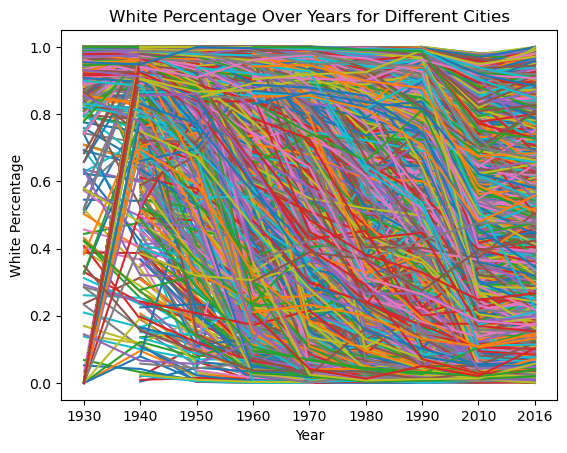

In [7]:
### Plotting white percentage for all rows in holc_data
years = ['1930','1940','1950','1960','1970','1980','1990','2010', '2016']
df = holc_data

rows, columns = df.shape

for i in range(rows):

  city_data = df.iloc[i]
  city_income = [city_data[f'white_perc_{year}'] for year in years]

  plt.plot(years, city_income, label=city_data.city)

plt.xlabel('Year')
plt.ylabel('White Percentage')
plt.title('White Percentage Over Years for Different Cities')
#plt.legend()
plt.show()

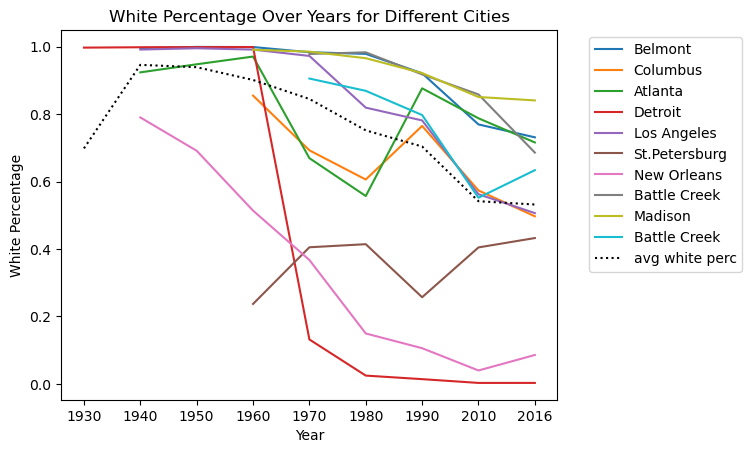

In [8]:
##this is way too dense, so I randomly sample 10 places to plot
#I also plot the avg values so there's a sense of all data

metric_name = "white_perc_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_white_perc = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_white_perc, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg white perc")

plt.xlabel('Year')
plt.ylabel('White Percentage')
plt.title('White Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

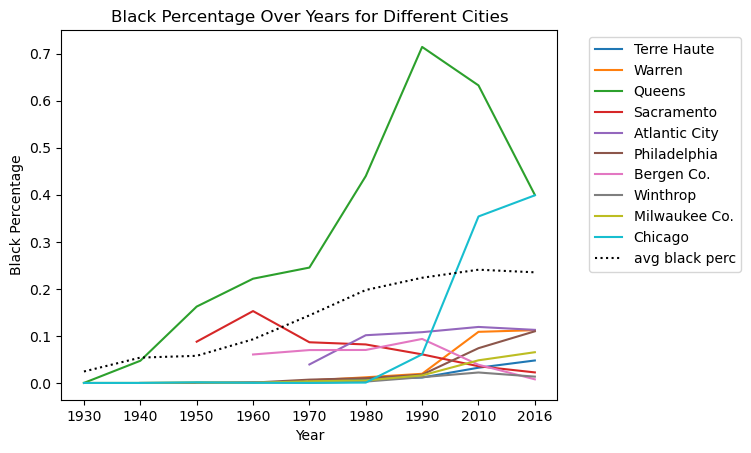

In [9]:
##black percentage
metric_name = "black_perc_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_black_perc = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_black_perc, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg black perc")

plt.xlabel('Year')
plt.ylabel('Black Percentage')
plt.title('Black Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

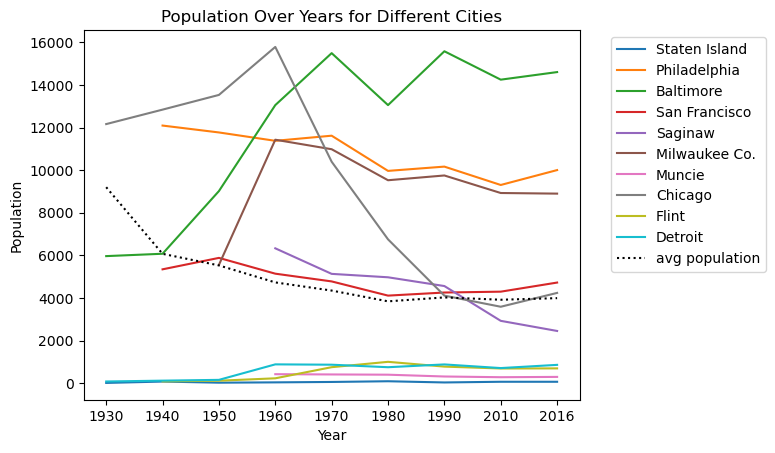

In [10]:
##population
metric_name = "population_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_population = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_population, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg population")

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The trend lines are very accurate for 1930-1950, because those years have >2800 missing values out of 8394 entries (>33%)

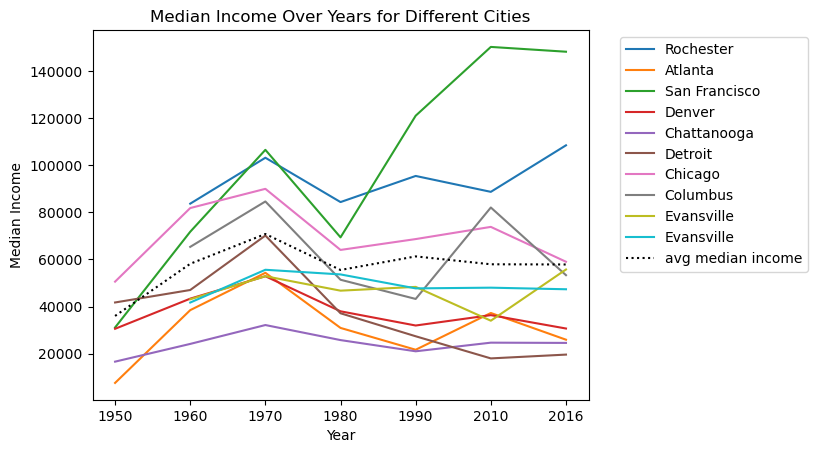

In [11]:
#there's no income data for 1930/40, so shortening year list
short_years = ['1950','1960','1970','1980','1990','2010', '2016']

metric_name = "median_inc_"

##this is way too dense, so I randomly sample 10 places to plot
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_income = [row[f'{metric_name}{year}'] for year in short_years]

  plt.plot(short_years, city_income, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in short_years]
plt.plot(short_years, avg_vals, linestyle=':', color='black', label="avg median income")

plt.xlabel('Year')
plt.ylabel('Median Income')
plt.title('Median Income Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

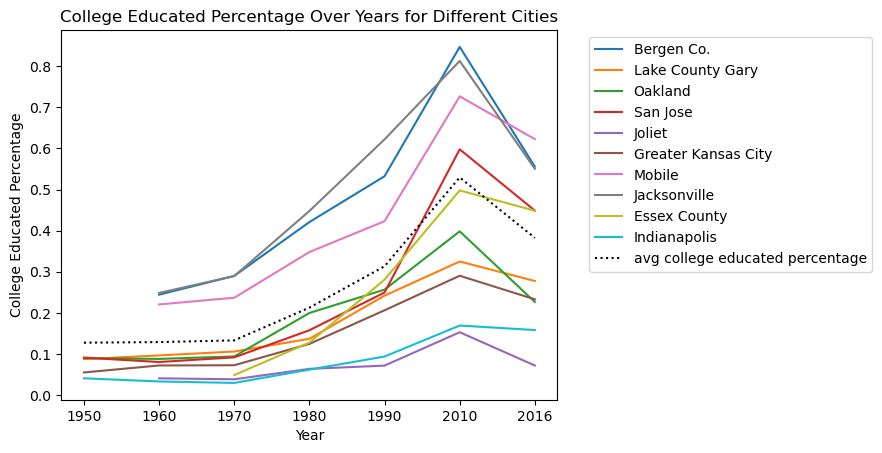

In [12]:
#college education
short_years = ['1950','1960','1970','1980','1990','2010', '2016']

metric_name = "college_perc_"

##this is way too dense, so I randomly sample 10 places to plot
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_data = [row[f'{metric_name}{year}'] for year in short_years]

  plt.plot(short_years, city_data, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in short_years]
plt.plot(short_years, avg_vals, linestyle=':', color='black', label="avg college educated percentage")

plt.xlabel('Year')
plt.ylabel('College Educated Percentage')
plt.title('College Educated Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


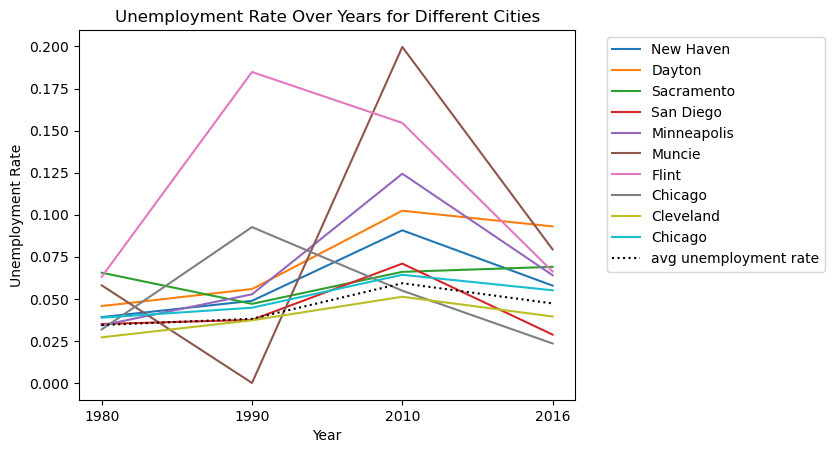

In [60]:
#unemployment data only starts in 1980
short_years = ['1980','1990','2010', '2016']

metric_name = "unemployed_perc_"

##this is way too dense, so I randomly sample 10 places to plot
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_data = [row[f'{metric_name}{year}'] for year in short_years]

  plt.plot(short_years, city_data, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in short_years]
plt.plot(short_years, avg_vals, linestyle=':', color='black', label="avg unemployment rate")

plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 1.3 Predicting HOLC grade using socioeconomic and demographic data during redlining (10 pts)
We believe that since HOLC grades are determinative of demographic and socioeconomic characteristics, we can back out grades by using some of these characteristics. Let's use some of these to predict HOLC grades. Here you will use the `holc_data` dataset. 

First, create `X` and `y` arrays contains our features and targets. 

In [85]:
#1980-present
# 'white_perc_1980', 'black_perc_1980', 'hispanic_perc_1980',
#        'other_perc_1980', 'college_perc_1980', 'median_inc_1980',
#        'unemployed_perc_1980', 'population_1990', 'white_perc_1990',
#        'black_perc_1990', 'hispanic_perc_1990', 'other_perc_1990',
#        'college_perc_1990', 'median_inc_1990', 'unemployed_perc_1990',
#        'population_2000', 'white_perc_2000', 'black_perc_2000',
#        'hispanic_perc_2000', 'other_perc_2000', 'college_perc_2000',
#        'median_inc_2000', 'unemployed_perc_2000', 'population_2010',
#        'white_perc_2010', 'black_perc_2010', 'hispanic_perc_2010',
#        'other_perc_2010', 'college_perc_2010', 'median_inc_2010',
#        'unemployed_perc_2010'

In [45]:
## insert your code here.
#here's all the data columns we are interested in
data_cols = [
       'population_1940', 'white_perc_1940', 'black_perc_1940',
       'population_1950', 'white_perc_1950', 'black_perc_1950',
       'other_perc_1950', 'college_perc_1950', 'median_inc_1950',
       'population_1960', 'white_perc_1960', 'hispanic_perc_1960',
       'black_perc_1960', 'other_perc_1960', 'college_perc_1960',
       'median_inc_1960', 'population_1970', 'white_perc_1970',
       'hispanic_perc_1970', 'black_perc_1970', 'other_perc_1970',
       'college_perc_1970', 'median_inc_1970', 'population_1980',
       ]

X = holc_data[data_cols]
y = holc_data['holc_grade']

Do we have any `NaN`s? Our ML models will not accept missing data. 

In [14]:
##yes, there are NaNs in the X values (not in the Y values) 
print(f"total NaNs in X: {X.isna().sum().sum()}")
print(f"total NaNs in y: {y.isna().sum()}")

total NaNs in X: 35125
total NaNs in y: 0


In order to assure we do not have any `NaNs` in our data, which , we'll replace all of our `NaN`s with the median of the column

In [46]:
## insert your code here. 
X =X.fillna(X.mean())

We'll also want standardize our data as well.

In [47]:
## insert your code here. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [58]:
#trying one-hot encoding, decreased accuracy :(
from sklearn.preprocessing import OneHotEncoder

# Example labels represented as strings
y_test = np.array(y)

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform OneHotEncoder to encode labels
y_encoded = one_hot_encoder.fit_transform(y_test.reshape(-1, 1))

y_encoded

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Now let's split our data into a train and test set. 

In [64]:
## insert your code here. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.33)

Using a `RandomForestClassifier` model, let's train our model to predict `y_train` on the input data `X_train` 

In [65]:
## insert your code here. 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

How well did our model do? Show the accuracy, F1, AUC ROC, log loss

In [66]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  # Assuming multi-class classification
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # One-vs-Rest (OvR) strategy for multi-class AUC-ROC
logloss = log_loss(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Log Loss:", logloss)

Accuracy: 0.5207506315409599


The performance was not so great, since the accuracy is only 52.8%.
AUC-ROC score is close to 1, which means the model has good discriminatory power between positive and negative instances. The lower log loss is better, so log loss of 1.12 shows a lot of uncertainty in the predictions.

Now try a different model and let's see if our results were better. 

In [20]:
## insert your code here.
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred_proba = gb.predict_proba(X_test)

Show the classification scores again for this new model. 

In [21]:
## insert your code here.
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  # Assuming multi-class classification
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # One-vs-Rest (OvR) strategy for multi-class AUC-ROC
logloss = log_loss(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Log Loss:", logloss)

Accuracy: 0.5272464814146518
F1 Score: 0.4932477483650105
AUC-ROC Score: 0.7920544742491072
Log Loss: 0.9964799440173722


Since the scores weren't so different, let's go back to the RF Classifier model and tune its hyperparamters, so we can look at feature importances later. Please explain what you chose to tune. 

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 9],
              'min_samples_split': [2, 5, 10, 20]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1)

In [97]:
grid.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_split': [2, 5, 10, 20]},
             verbose=1)

In [98]:
sorted(grid.cv_results_.keys())
grid.best_params_

{'max_depth': 9, 'min_samples_split': 5}

In [22]:
## I chose to tune the train/test split (0.8/0.2 is better than 0.7/0.3)
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2)

#and from the grid search I tuned max depth and min samples
rf_tuned = RandomForestClassifier(max_depth=9, min_samples_split=5)
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
y_pred_proba = rf_tuned.predict_proba(X_test)

print("Accuracy: ", rf_tuned.score(X_test, y_test))

Accuracy:  0.5342465753424658


In [23]:
#I also tested accuracy of model across different folds
#and the model performance seems consistent with what I got above

from sklearn.model_selection import cross_val_score
scores_tuned = cross_val_score(rf_tuned, X_train, y_train, cv=5)
scores = cross_val_score(rf, X_train, y_train, cv=5)

print(scores_tuned.mean(), scores.mean())

0.5364110201042442 0.5230081906180193


Now, how well did you prediction improve? 

In [24]:
### insert your code here
print(f"improvement in test set performance: {0.5306 -0.528}")

print(f"improvement in cross validation accuracy: {scores_tuned.mean() - scores.mean()}")



improvement in test set performance: 0.0025999999999999357
improvement in cross validation accuracy: 0.013402829486224954


This is a 0.02% increase in test set accuracy, or 1% in cross validation accuracy, which is barely any. I think the overall poor model performance could be because there were a lot of missing data in 1940-1960 that were filled with mean values. Perhaps a better way is to drop these values altogether? Or to not train models on rows with missing data.

## 1.4 Feature importances (3pts)
Create a plot of the feature importances for each feature. You can use the sample code here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

- What seems to be most important features in determining outcomes? 
- Is this surprising? What did you expect to be more important? 

In [104]:
## insert your code here.   
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [105]:
importances

array([0.02098914, 0.02072784, 0.01863075, 0.02623273, 0.02777149,
       0.02602176, 0.02465173, 0.04425819, 0.03424686, 0.04042123,
       0.0413273 , 0.02670693, 0.03809098, 0.03772288, 0.08018376,
       0.06428131, 0.05192278, 0.0434864 , 0.04424968, 0.04334283,
       0.04223425, 0.07835779, 0.06504829, 0.05909309])

In [106]:
df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
14,college_perc_1960,0.080184
21,college_perc_1970,0.078358
22,median_inc_1970,0.065048
15,median_inc_1960,0.064281
23,population_1980,0.059093
16,population_1970,0.051923
7,college_perc_1950,0.044258
18,hispanic_perc_1970,0.044250
17,white_perc_1970,0.043486
19,black_perc_1970,0.043343


## 1.5 Predicting with pre-redlining data (10 pts)
We're going to use the 1930s data and the change between 1930 and 1940, since we don't really have a lot of data for 1930.

- How did the scores change? 
- What were the most important features and is this surprising? 

First, create the `population_1940_1930_diff`, `black_perc_1940_1930_diff`, `white_perc_1940_1930_diff` variables that show the change in these three between 1930 and 1940. 

In [124]:
## insert your code here.
data_cols = ['population_1930', 'white_perc_1930', 'black_perc_1930',
       'population_1940', 'white_perc_1940', 'black_perc_1940']

X = holc_data[data_cols]
X =X.fillna(X.mean()) #fill na values with mean

X["population_1940_1930_diff"] = X["population_1940"] - X["population_1930"]
X["black_perc_1940_1930_diff"] = X["black_perc_1940"] - X["black_perc_1930"]
X["white_perc_1940_1930_diff"] = X["white_perc_1940"] - X["white_perc_1930"]

Now run a classification model again. 

In [128]:
## insert your code here.
data_cols = ['population_1930', 'white_perc_1930', 'black_perc_1930',
      "population_1940_1930_diff", "black_perc_1940_1930_diff",
      "white_perc_1940_1930_diff"]
X = X[data_cols]
y = holc_data['holc_grade']

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

And show how well the model did and whether the scores changed. 

In [127]:
## insert your code here.
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4044073853484217


The model performed worse than when it was fit on redlining period data. There's about an 10% accuracy decrease.

And what are the feature importances? 

In [129]:
## insert your code here.
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
3,population_1940_1930_diff,0.293059
4,black_perc_1940_1930_diff,0.258063
5,white_perc_1940_1930_diff,0.242264
0,population_1930,0.095724
2,black_perc_1930,0.058313
1,white_perc_1930,0.052576


The difference between 1940 and 1930 is more important than the 1930 data, which is expected because a lot of the data in 1930 is NaN. Further, it is expected that this model performs worse that when fit on redlining period data, which has less missing values.

## Bonus: Feature creation (5 pts)
Let's say we think that the distance to the center of the city matters in terms of what the grade might be. 
- Create a new column called `dist_center` that is the distance from the centroid of each neighborhood (row) to the centroid of all the rows for each `city`. 
- Include this new column in your model. 
- Did it improve your scores? 



In [140]:
## insert your code here.
##TODO: is this just for pre-redlining data?

from shapely.geometry import Point

# helper functions to calculate centroid and distance
def calculate_centroid(geometry):
    return geometry.centroid

def calculate_distance(row):
    return row['geometry'].distance(row['city_centroid'])

# Group by city and calculate the centroid of each city
city_centroids = holc_data.groupby('city')['geometry'].apply(lambda x: calculate_centroid(x.geometry.unary_union))

# Merge the centroids back to the original GeoDataFrame
holc_data = holc_data.merge(city_centroids.rename('city_centroid'), left_on='city', right_index=True)

# Calculate distance between district centroids and city centroids
holc_data['distance_center'] = holc_data.apply(calculate_distance, axis=1)


,city,holc_grade,holc_id,population_2016,white_perc_2016,black_perc_2016,hispanic_perc_2016,other_perc_2016,college_perc_2016,median_inc_2016,...,white_perc_2010,black_perc_2010,hispanic_perc_2010,other_perc_2010,college_perc_2010,median_inc_2010,unemployed_perc_2010,geometry,city_centroid,distance_to_city
0,Akron,C,654,608.030951,0.115634,8.061993e-01,0.034411,0.043756,0.313643,18515.902688,...,0.091516,0.872694,0.012581,0.025292,0.287267,23963.085025,0.144550,"POLYGON ((-81.56979 41.07054, -81.58386 41.070...",POINT (-81.51245 41.07583),0.057235
1,Albany,D,3660,42.562494,0.222222,5.354610e-01,0.196217,0.145390,0.269504,41250.000000,...,0.244919,0.623984,0.072154,0.067073,0.437343,38487.696300,0.093496,"POLYGON ((-73.73995 42.67020, -73.74168 42.667...",POINT (-73.78552 42.65704),0.042553
2,Altoona,B,2100,108.165867,0.918022,0.000000e+00,0.000000,0.081978,0.293845,45974.141998,...,0.980376,0.005583,0.002806,0.011234,0.446091,47893.836030,0.014034,"POLYGON ((-78.38951 40.50126, -78.38345 40.497...",POINT (-78.39914 40.51092),0.013642
3,Bay City,C,5155,382.028184,0.925245,2.914050e-08,0.074754,0.000002,0.354369,43138.285274,...,0.923273,0.017609,0.032706,0.027671,0.313855,56764.206090,0.090570,"POLYGON ((-83.84960 43.58044, -83.85901 43.580...",POINT (-83.88575 43.59362),0.027896
4,Cambridge,B,5459,186.388926,0.823683,0.000000e+00,0.082445,0.160808,0.715933,113102.144508,...,0.860163,0.021113,0.039059,0.081636,0.961904,147764.208313,0.007882,"POLYGON ((-71.13800 42.37454, -71.13674 42.374...",POINT (-71.11158 42.37727),0.024508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8390,Youngstown,C,2260,2286.552724,0.847073,1.226776e-01,0.027564,0.007020,0.276580,36845.513426,...,0.903851,0.045113,0.036715,0.014774,0.301589,38042.551582,0.059173,"POLYGON ((-80.61548 41.04985, -80.62884 41.049...",POINT (-80.63760 41.08955),0.030445
8391,Youngstown,D,2246,6680.437142,0.579759,2.178599e-01,0.170413,0.086836,0.215808,29188.617159,...,0.622392,0.211077,0.136161,0.032297,0.258703,34506.860896,0.090457,"POLYGON ((-80.59428 41.09069, -80.59432 41.088...",POINT (-80.63760 41.08955),0.021271
8392,Youngstown,D,2247,2102.391606,0.511383,3.536587e-01,0.052796,0.120464,0.134929,14762.247448,...,0.587953,0.295551,0.071793,0.046346,0.295924,18750.106072,0.057094,"POLYGON ((-80.67684 41.10181, -80.68290 41.102...",POINT (-80.63760 41.08955),0.041112
8393,Youngstown,C,2248,5170.242027,0.727877,1.634934e-01,0.092156,0.036810,0.276456,30923.799351,...,0.751176,0.156663,0.061487,0.032293,0.310563,34466.541597,0.097456,"POLYGON ((-80.67684 41.10181, -80.67553 41.101...",POINT (-80.63760 41.08955),0.039078


In [162]:
holc_data

,city,holc_grade,holc_id,population_2016,white_perc_2016,black_perc_2016,hispanic_perc_2016,other_perc_2016,college_perc_2016,median_inc_2016,...,white_perc_2010,black_perc_2010,hispanic_perc_2010,other_perc_2010,college_perc_2010,median_inc_2010,unemployed_perc_2010,geometry,city_centroid,distance_center
0,Akron,C,654,608.030951,0.115634,8.061993e-01,0.034411,0.043756,0.313643,18515.902688,...,0.091516,0.872694,0.012581,0.025292,0.287267,23963.085025,0.144550,"POLYGON ((-81.56979 41.07054, -81.58386 41.070...",POINT (-81.51245 41.07583),0.057235
1,Albany,D,3660,42.562494,0.222222,5.354610e-01,0.196217,0.145390,0.269504,41250.000000,...,0.244919,0.623984,0.072154,0.067073,0.437343,38487.696300,0.093496,"POLYGON ((-73.73995 42.67020, -73.74168 42.667...",POINT (-73.78552 42.65704),0.042553
2,Altoona,B,2100,108.165867,0.918022,0.000000e+00,0.000000,0.081978,0.293845,45974.141998,...,0.980376,0.005583,0.002806,0.011234,0.446091,47893.836030,0.014034,"POLYGON ((-78.38951 40.50126, -78.38345 40.497...",POINT (-78.39914 40.51092),0.013642
3,Bay City,C,5155,382.028184,0.925245,2.914050e-08,0.074754,0.000002,0.354369,43138.285274,...,0.923273,0.017609,0.032706,0.027671,0.313855,56764.206090,0.090570,"POLYGON ((-83.84960 43.58044, -83.85901 43.580...",POINT (-83.88575 43.59362),0.027896
4,Cambridge,B,5459,186.388926,0.823683,0.000000e+00,0.082445,0.160808,0.715933,113102.144508,...,0.860163,0.021113,0.039059,0.081636,0.961904,147764.208313,0.007882,"POLYGON ((-71.13800 42.37454, -71.13674 42.374...",POINT (-71.11158 42.37727),0.024508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8390,Youngstown,C,2260,2286.552724,0.847073,1.226776e-01,0.027564,0.007020,0.276580,36845.513426,...,0.903851,0.045113,0.036715,0.014774,0.301589,38042.551582,0.059173,"POLYGON ((-80.61548 41.04985, -80.62884 41.049...",POINT (-80.63760 41.08955),0.030445
8391,Youngstown,D,2246,6680.437142,0.579759,2.178599e-01,0.170413,0.086836,0.215808,29188.617159,...,0.622392,0.211077,0.136161,0.032297,0.258703,34506.860896,0.090457,"POLYGON ((-80.59428 41.09069, -80.59432 41.088...",POINT (-80.63760 41.08955),0.021271
8392,Youngstown,D,2247,2102.391606,0.511383,3.536587e-01,0.052796,0.120464,0.134929,14762.247448,...,0.587953,0.295551,0.071793,0.046346,0.295924,18750.106072,0.057094,"POLYGON ((-80.67684 41.10181, -80.68290 41.102...",POINT (-80.63760 41.08955),0.041112
8393,Youngstown,C,2248,5170.242027,0.727877,1.634934e-01,0.092156,0.036810,0.276456,30923.799351,...,0.751176,0.156663,0.061487,0.032293,0.310563,34466.541597,0.097456,"POLYGON ((-80.67684 41.10181, -80.67553 41.101...",POINT (-80.63760 41.08955),0.039078


In [152]:
X["distance_center"] = holc_data["distance_center"]
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = holc_data['holc_grade']

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3579511614055986


In [154]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

data_cols = ['population_1930', 'white_perc_1930', 'black_perc_1930',
      "population_1940_1930_diff", "black_perc_1940_1930_diff",
      "white_perc_1940_1930_diff", "distance_center"]
df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
6,distance_center,0.595809
3,population_1940_1930_diff,0.110754
4,black_perc_1940_1930_diff,0.103134
5,white_perc_1940_1930_diff,0.099203
0,population_1930,0.040719
2,black_perc_1930,0.026518
1,white_perc_1930,0.023864


# 2. Predicting NYC taxi pick-up and drop-offs (40 pts)
In this exercise, we will be trying to predict where a taxi is being picked up based on where it's dropped off. 

That is: we want to predict the `PULocationID` using the rest of the data. 

This data is from: 
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

- Please familiarize yourself with the data dictionary and the taxi zones. 
- Would it make sense to add more features by bringing in more data through, for ex, the census? 

In [29]:
### You will have to download the data from the link above
### A parquet file is a file format that is very efficient for
### storing dataframes. 

taxi_data = pd.read_parquet('yellow_tripdata_2024-01.parquet')

In [34]:
#data dictionary:
#https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

#shape of the dataframe
taxi_data.shape

(2964624, 19)

In [35]:
#inspect null values
taxi_data.isnull().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

It seems like missing values are only in specific columns, but these are categorical values so taking the mean probably isn't a good approach. Instead, I just omit these values for my first attempt of training a model.

In [69]:
#columns with missing data:
#'passenger_count', 'RatecodeID', 'store_and_fwd_flag',' congestion_surcharge', 'Airport_fee'

#also ignore time for now: 'tpep_pickup_datetime', 'tpep_dropoff_datetime',

data_cols = ['VendorID', 'trip_distance', 'PULocationID', 'payment_type', 'fare_amount','extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge','total_amount']

X = taxi_data[data_cols]
y = taxi_data['DOLocationID']

In [43]:
#standardize the data
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
#way too big, will try to randomly sample 10,000

taxi_data_small = taxi_data.sample(n=1000, random_state=42)
X = taxi_data_small[data_cols]
y = taxi_data_small['DOLocationID']
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

MemoryError: could not allocate 10551296 bytes